In [2]:
#Import all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [152]:
#import data
df = pd.read_csv("../data/len_train.csv")
test = pd.read_csv("../data/len_test.csv")


In [72]:
df.drop(['store_and_fwd_flag', 'vendor_id'], axis=1, inplace=True)
test.drop(['store_and_fwd_flag', 'vendor_id'], axis=1, inplace=True)

### Lets do some exploration on our data

In [153]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [76]:
print(df.shape)
print(test.shape)

(1458644, 9)
(625134, 7)


In [77]:
df.dtypes

id                    object
pickup_datetime       object
dropoff_datetime      object
passenger_count        int64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_duration          int64
dtype: object

We have three categorical variables (ignoring id), which we will need to modify

In [78]:
#Count the number of NaN values for each column
df.isna().sum()

id                   0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
trip_duration        0
dtype: int64

### lets remove outliers

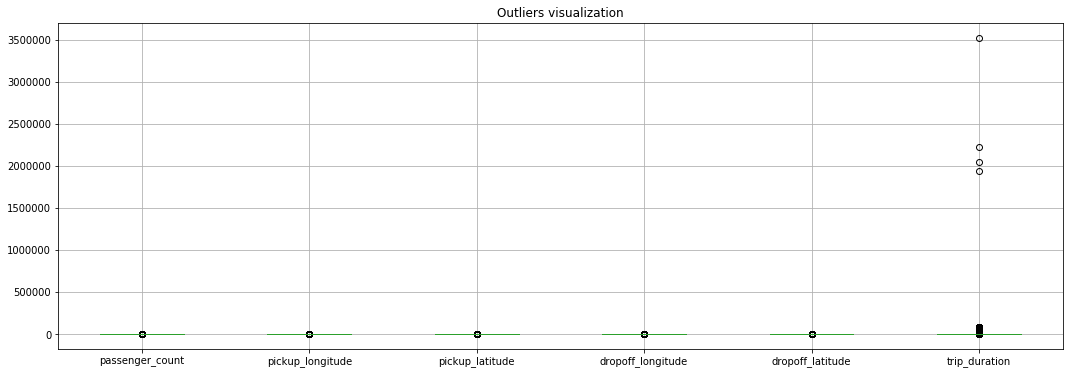

In [79]:
#Visualize univariate outliers
plt.subplots(figsize=(18,6))
plt.title("Outliers visualization")
df.boxplot();

We can see that the trip_duration column has some outliers which we can assume these exist as a result of missrecording, therefore we will delete them.

In [80]:
#set the bound for trips we believe to be wrong as two hours (7200 seconds)
df = df[(df.trip_duration < 7200)]

In [81]:
#We also see when calling df.describe() that there are trips with 0 passengers
#We should delete these
df = df[(df.passenger_count > 0)]

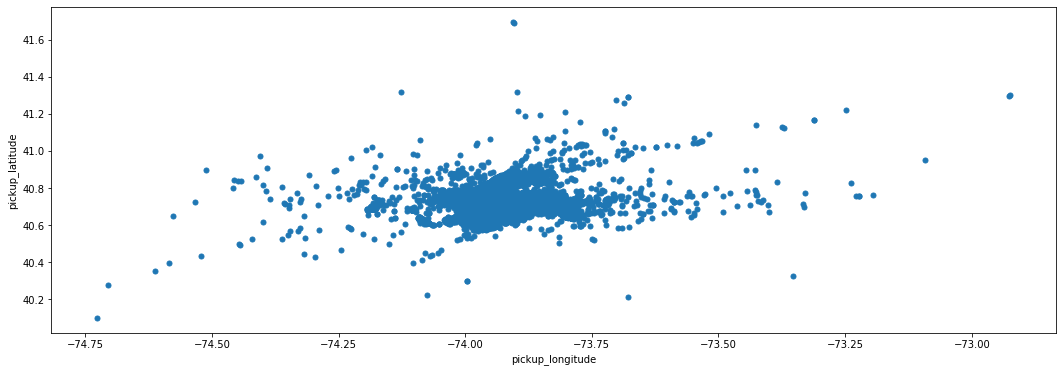

In [85]:
#Plot pickup positions to visualize outliers
pickup_longitude = list(df.pickup_longitude)
pickup_latitude = list(df.pickup_latitude)
plt.subplots(figsize=(18,6))
plt.plot(pickup_longitude, pickup_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.show()

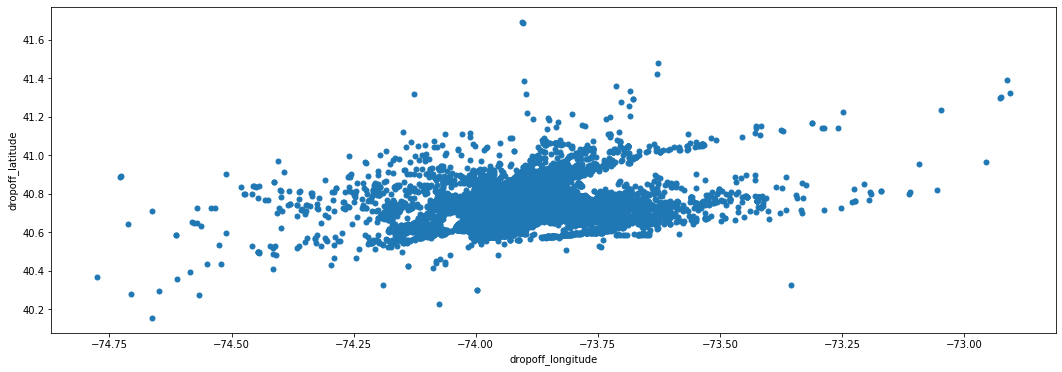

In [86]:
#Plot dropoff positions to visualize outliers
dropoff_longitude = list(df.dropoff_longitude)
dropoff_latitude = list(df.dropoff_latitude)
plt.subplots(figsize=(18,6))
plt.plot(dropoff_longitude, dropoff_latitude, '.', alpha = 1, markersize = 10)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.show()

In [84]:
#Remove position outliers
df = df[(df.pickup_longitude > -75)]
df = df[(df.pickup_longitude < -72.8)]
df = df[(df.pickup_latitude < 42.5)]
df = df[(df.pickup_latitude > 40)]
df = df[(df.dropoff_longitude > -75)]
df = df[(df.dropoff_longitude < -72.8)]
df = df[(df.dropoff_latitude < 42.5)]
df = df[(df.dropoff_latitude > 40)]

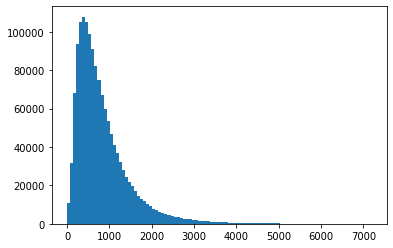

In [87]:
#lets see if our target needs normalizingplt.subplots(figsize=(18,6))
plt.hist(df['trip_duration'].values, bins=100)
plt.show()

We should probably apply a log to this column

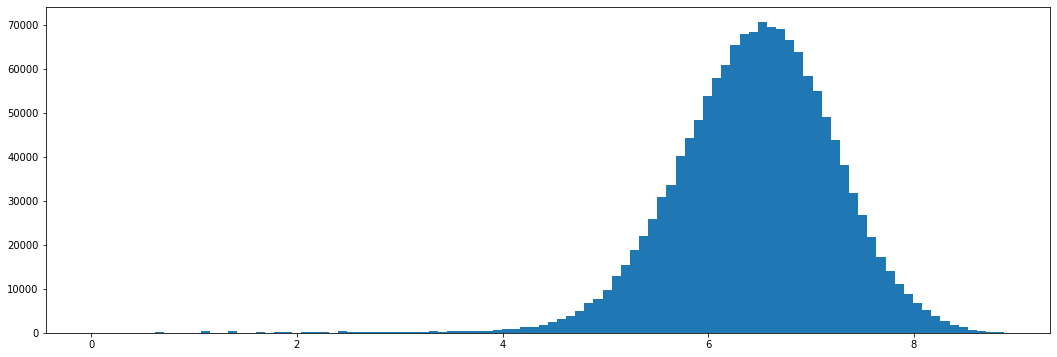

In [88]:
plt.subplots(figsize=(18,6))
df['trip_duration'] = np.log(df['trip_duration'].values)
plt.hist(df['trip_duration'].values, bins=100)
plt.show()

Next we will deal with dates

In [90]:
#Datetyping the dates
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

df.drop(['dropoff_datetime'], axis=1, inplace=True) #as we don't have this feature in the testset

#Date features creations and deletions
df['month'] = df.pickup_datetime.dt.month
df['week'] = df.pickup_datetime.dt.week
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour
df['minute'] = df.pickup_datetime.dt.minute
df['minute_oftheday'] = df['hour'] * 60 + df['minute']
df.drop(['minute'], axis=1, inplace=True)

test['month'] = test.pickup_datetime.dt.month
test['week'] = test.pickup_datetime.dt.week
test['weekday'] = test.pickup_datetime.dt.weekday
test['hour'] = test.pickup_datetime.dt.hour
test['minute'] = test.pickup_datetime.dt.minute
test['minute_oftheday'] = test['hour'] * 60 + test['minute']
test.drop(['minute'], axis=1, inplace=True)

df.drop(['pickup_datetime'], axis=1, inplace=True)


### Lets get modelling!

In [91]:
#Split the labeled data frame into two sets: features and target
y = df["trip_duration"]
df.drop(["trip_duration"], axis=1, inplace=True)
df.drop(['id'], axis=1, inplace=True)
X = df

X.shape, y.shape

((1456293, 10), (1456293,))

In [92]:
#Split the labeled data frame into two sets to train then test the models
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1165034, 10), (1165034,), (291259, 10), (291259,))

In [93]:
from sklearn.metrics import mean_squared_error as MSE

In [94]:
%%time

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train), rf.score(X_test, y_test))
print(np.sqrt(MSE(y_test, rf.predict(X_test))))


/Users/juanmarin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9552907440584737 0.754606197758205
0.3866015864586612
CPU times: user 2min 3s, sys: 858 ms, total: 2min 4s
Wall time: 2min 4s


In [95]:
rf = RandomForestRegressor(n_estimators=150, min_samples_leaf=10, min_samples_split=15, max_features='auto', max_depth=50, bootstrap=True, n_jobs=-1)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [96]:
test_columns = X.columns
predictions = rf.predict(test[test_columns])

In [97]:
preds = pd.DataFrame({'id': test.id, 'trip_duration': np.exp(predictions)})
preds.head(10)

,id,trip_duration
0,id3004672,740.148857
1,id3505355,625.473415
2,id1217141,498.051757
3,id2150126,1059.323944
4,id1598245,376.082518
5,id0668992,981.803564
6,id1765014,1275.383982
7,id0898117,668.499680
8,id3905224,2418.108863
9,id1543102,587.140260


Lets test with google maps

In [57]:
rightnow = test["minute_oftheday"] == 473
testing_time = test[rightnow]

In [58]:
testing_time.head(10)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,N,Y,1,2,month,week,weekday,hour,minute_oftheday
2732,id1236335,1,2016-06-30 07:53:50,1,-74.001617,40.745754,-73.967110,40.760441,N,1,0,1,0,6,26,3,7,473
2733,id0794196,2,2016-06-30 07:53:03,6,-73.946648,40.772339,-74.005371,40.706310,N,1,0,0,1,6,26,3,7,473
2734,id1564726,2,2016-06-30 07:53:01,1,-73.995811,40.758934,-73.981422,40.757915,N,1,0,0,1,6,26,3,7,473
9218,id2872344,1,2016-06-28 07:53:01,1,-73.991440,40.748116,-73.985710,40.748558,N,1,0,1,0,6,26,1,7,473
12253,id2890883,1,2016-06-27 07:53:59,3,-74.017136,40.705383,-73.970741,40.751156,N,1,0,1,0,6,26,0,7,473
12254,id1928953,2,2016-06-27 07:53:46,1,-73.983727,40.740860,-74.006851,40.727360,N,1,0,0,1,6,26,0,7,473
12255,id0441470,2,2016-06-27 07:53:43,1,-73.991241,40.749771,-74.003372,40.714291,N,1,0,0,1,6,26,0,7,473
12256,id1261805,1,2016-06-27 07:53:39,1,-73.978760,40.747452,-73.980957,40.765533,N,1,0,1,0,6,26,0,7,473
12257,id3438275,2,2016-06-27 07:53:33,1,-73.987518,40.738419,-73.978447,40.750568,N,1,0,0,1,6,26,0,7,473
14845,id2065537,1,2016-06-26 07:53:37,1,-73.987640,40.691322,-73.986191,40.672443,N,1,0,1,0,6,25,6,7,473


In [59]:
new_predictions = rf.predict(testing_time[test_columns])
new_preds = pd.DataFrame({'id': testing_time.id, 'trip_duration': np.exp(new_predictions)})
new_preds.head(10)

,id,trip_duration
2732,id1236335,1010.795584
2733,id0794196,1088.790246
2734,id1564726,455.825092
9218,id2872344,375.312520
12253,id2890883,1171.072618
12254,id1928953,769.932838
12255,id0441470,961.434470
12256,id1261805,804.842045
12257,id3438275,397.691852
14845,id2065537,496.674141


In [60]:
testing_time[test_columns]

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,N,Y,1,2,month,week,weekday,hour,minute_oftheday
2732,1,-74.001617,40.745754,-73.967110,40.760441,1,0,1,0,6,26,3,7,473
2733,6,-73.946648,40.772339,-74.005371,40.706310,1,0,0,1,6,26,3,7,473
2734,1,-73.995811,40.758934,-73.981422,40.757915,1,0,0,1,6,26,3,7,473
9218,1,-73.991440,40.748116,-73.985710,40.748558,1,0,1,0,6,26,1,7,473
12253,3,-74.017136,40.705383,-73.970741,40.751156,1,0,1,0,6,26,0,7,473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610160,1,-73.994530,40.736740,-74.002640,40.748833,1,0,0,1,1,1,2,7,473
610161,1,-73.863586,40.769836,-73.869164,40.839611,1,0,0,1,1,1,2,7,473
613271,4,-73.991051,40.734009,-74.005508,40.707390,1,0,0,1,1,1,1,7,473
613272,3,-73.956268,40.771240,-73.956268,40.771240,1,0,0,1,1,1,1,7,473


### Export model using pickle

In [98]:
import pickle
filename = 'length_model.sav'
pickle.dump(rf, open(filename, 'wb'))

length_model.sav             prediction_pipeline.ipynb
predict length of trip.ipynb prize_model.sav
predict_price.ipynb


In [100]:
### pipeline template

In [101]:
loaded_model = pickle.load(open("length_model.sav", 'rb'))

In [138]:
d = {'pickup_datetime': ['2020-12-12 17:59:58'], 'passenger_count': [1],  'pickup_latitude' : [40.763805], 'dropoff_longitude' : [-73.981430], 'dropoff_latitude' : [40.743835],'pickup_longitude' : [-73.973320]}
manual_df = pd.DataFrame(data=d)

In [139]:
manual_df

,pickup_datetime,passenger_count,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_longitude
0,2020-12-12 17:59:58,1,40.763805,-73.98143,40.743835,-73.97332


In [140]:
manual_df['pickup_datetime'] = pd.to_datetime(manual_df.pickup_datetime)
manual_df['month'] = manual_df.pickup_datetime.dt.month
manual_df['week'] = manual_df.pickup_datetime.dt.week
manual_df['weekday'] = manual_df.pickup_datetime.dt.weekday
manual_df['hour'] = manual_df.pickup_datetime.dt.hour
manual_df['minute'] = manual_df.pickup_datetime.dt.minute
manual_df['minute_oftheday'] = manual_df['hour'] * 60 + manual_df['minute']
manual_df.drop(['minute'], axis=1, inplace=True)

In [141]:
X.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'month', 'week', 'weekday',
       'hour', 'minute_oftheday'],
      dtype='object')

In [142]:
test_columns = X.columns
predictions = rf.predict(manual_df[test_columns])

In [143]:
predictions

array([6.4662578])

In [154]:
#pipeline
def get_time_pipeline(timestamp, n_passengers, pickup_latitude, dropoff_longitude, dropoff_latitude, pickup_longitude):
    d = {'pickup_datetime': [timestamp], 'passenger_count': [n_passengers],  'pickup_latitude' : [pickup_latitude], 'dropoff_longitude' : [dropoff_longitude], 'dropoff_latitude' : [dropoff_latitude],'pickup_longitude' : [pickup_longitude]}
    manual_df = pd.DataFrame(data=d)
    manual_df['pickup_datetime'] = pd.to_datetime(manual_df.pickup_datetime)
    manual_df['month'] = manual_df.pickup_datetime.dt.month
    manual_df['week'] = manual_df.pickup_datetime.dt.week
    manual_df['weekday'] = manual_df.pickup_datetime.dt.weekday
    manual_df['hour'] = manual_df.pickup_datetime.dt.hour
    manual_df['minute'] = manual_df.pickup_datetime.dt.minute
    manual_df['minute_oftheday'] = manual_df['hour'] * 60 + manual_df['minute']
    manual_df.drop(['minute'], axis=1, inplace=True)
    
    col_order = ['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'month', 'week', 'weekday',
       'hour', 'minute_oftheday']
    
    predictions = np.exp(loaded_model.predict(manual_df[col_order]))
    
    return predictions

In [155]:
get_time_pipeline('2020-12-12 17:59:58', 1, 40.763805, -73.981430, 40.743835, -73.973320)

array([643.07270885])